<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/Ejercicio_Jumanji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

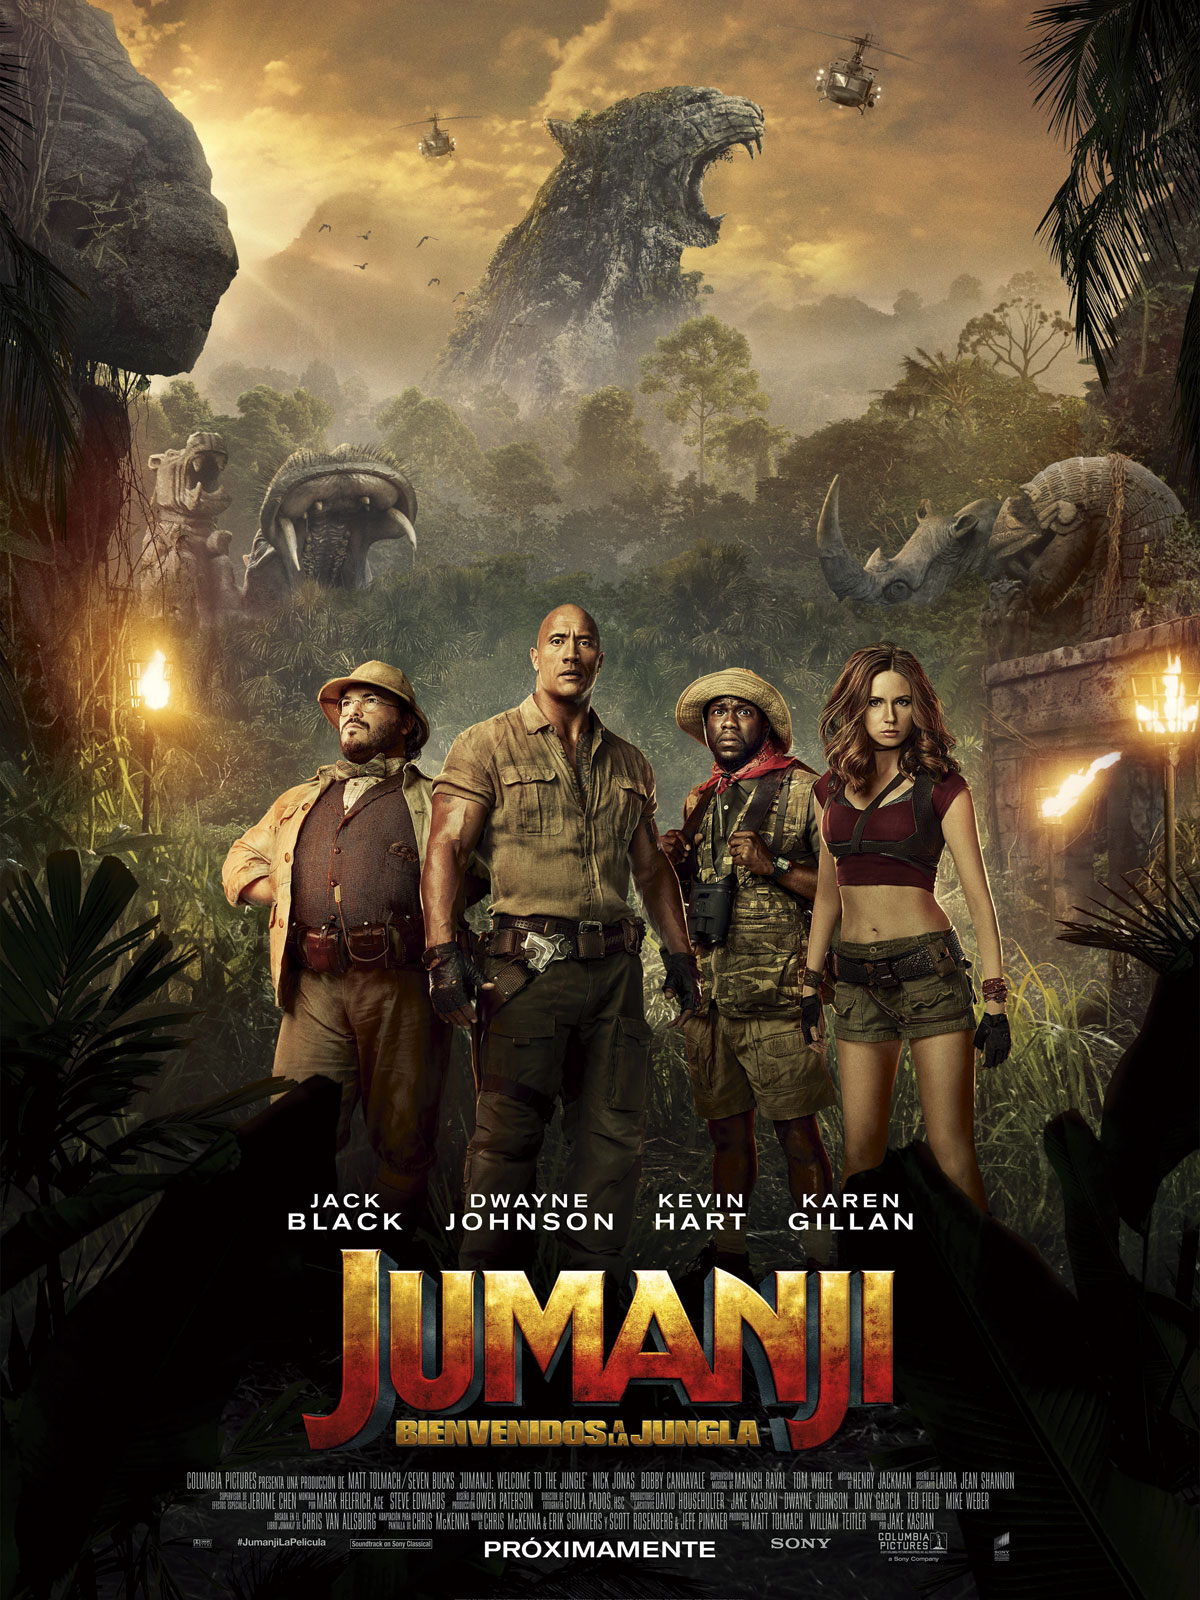

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [75]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

--2022-01-15 16:15:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   200MB/s    in 0.3s    

2022-01-15 16:15:07 (200 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [76]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

## Visualizacion de los datos


In [77]:
fich_cats = glob("./cats_and_dogs_filtered/train/cats/*")
fich_cats[0]

'./cats_and_dogs_filtered/train/cats/cat.976.jpg'

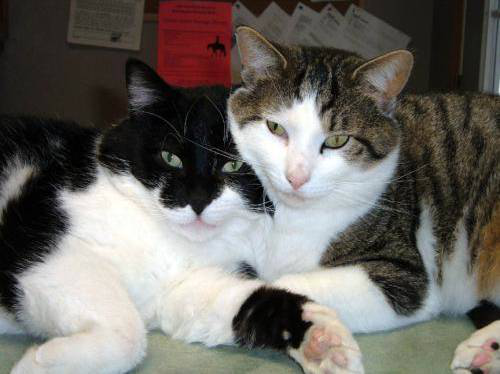

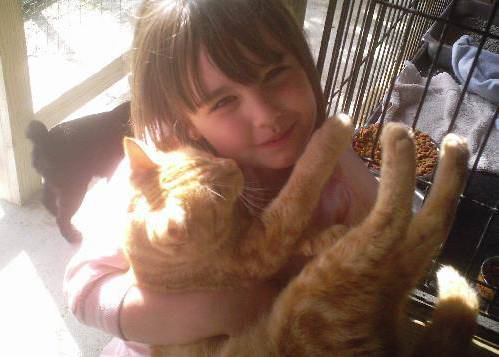

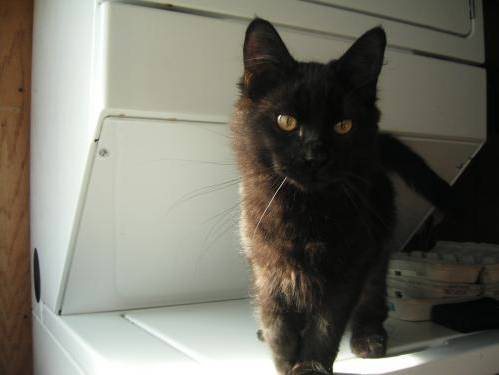

In [78]:
for fich in fich_cats[0:3]:
    imagen = load_img(fich)
    display(imagen)
    print()

In [79]:
fich_dogs = glob("./cats_and_dogs_filtered/train/dogs/*")
fich_dogs[0]

'./cats_and_dogs_filtered/train/dogs/dog.362.jpg'

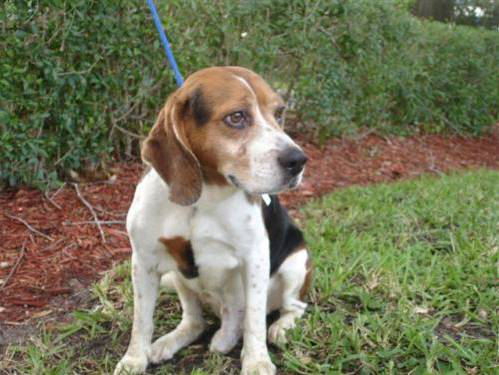

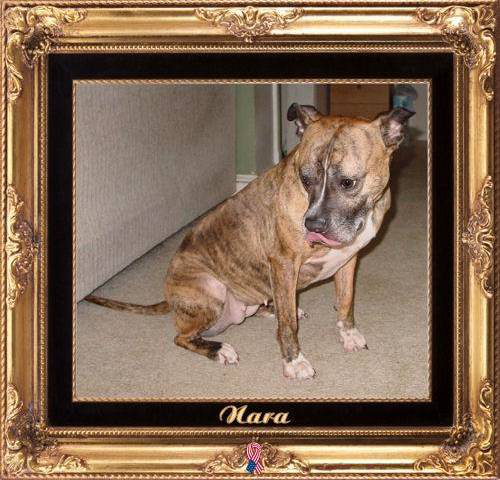

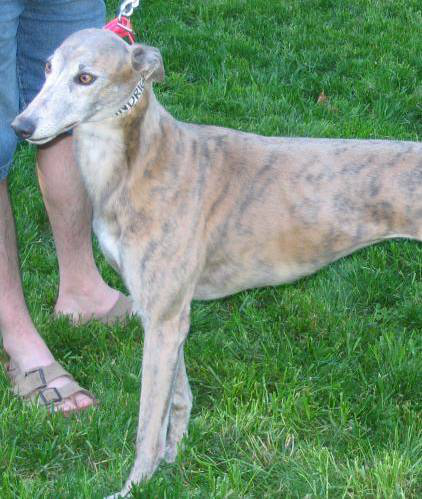

In [80]:
for fich in fich_dogs[0:3]:
    imagen = load_img(fich)
    display(imagen)
    print()

## Data aumentation: rotation.



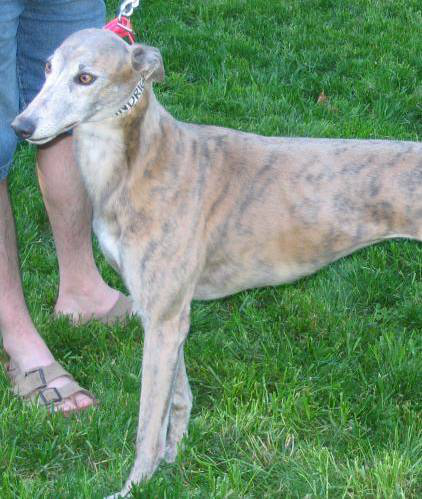

In [81]:
imagen = load_img(fich)
imagen

In [82]:
def preprocess_input(x):
     return x/255.


In [83]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=60)

In [84]:
imagen_num = np.expand_dims(np.array(imagen), axis=0)

In [85]:
imagen_num.shape

(1, 499, 422, 3)

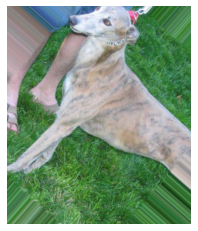

In [86]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## Image size


In [87]:
img_width, img_height = 120, 120

normed_dims = (img_height, img_width)

## Architechture 1

In [88]:
model = Sequential()

model.add(Conv2D(8, (3,3), activation='relu', input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(20, activation='relu', kernel_regularizer="l2")) # regularizador L2
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 118, 118, 8)       224       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 59, 59, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 32)      

In [90]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [91]:
train_data_dir = ('./cats_and_dogs_filtered/train')

In [92]:
validation_data_dir = ('./cats_and_dogs_filtered/validation')

In [93]:
batch_size = 16

In [94]:
validation_data_dir, normed_dims

('./cats_and_dogs_filtered/validation', (120, 120))

In [95]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [96]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [97]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

number_train_samples, number_val_samples

(2000, 1000)

In [98]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [99]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [100]:
epochs = 40

modelpath="model_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

KeyboardInterrupt: ignored

In [ ]:
model = load_model(modelpath)

## Resultados Architechture 1


In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()


In [ ]:
y_real = validation_generator.classes
y_pred_proba = model.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

test - val

In [ ]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio validation
    shuffle=False,
    class_mode='categorical')

In [ ]:
validation_generator2.reset()
X_val, y_val = validation_generator2.next()

In [ ]:
X_val.shape

In [ ]:
X_val.max()

In [ ]:
class_indices = validation_generator2.class_indices
class_indices

In [ ]:
ind_val1 = 84

image = X_val[ind_val1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## Early layer feature Maps Architechture 1


In [ ]:
# salida de una sola capa
ncapa = 0
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[ncapa].output)

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [ ]:
imagen = X_val[84]
imagen.shape

In [ ]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Late layer feature Maps Architechture 1




In [ ]:
# salida de una sola capa
ncapa = 0

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa+4].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [ ]:
imagen = X_val[84]
imagen.shape

In [ ]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Architechture 2

In [ ]:
model2 = Sequential()

model2.add(Conv2D(32, (5,5), activation='relu', input_shape=normed_dims+(3,)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(32, (5,5), activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64, (5,5), activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())

model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [ ]:
train_data_dir = ('./cats_and_dogs_filtered/train')

In [ ]:
validation_data_dir = ('./cats_and_dogs_filtered/validation')

In [ ]:
batch_size = 16

In [ ]:
validation_data_dir, normed_dims

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

In [ ]:
train_generator.class_indices

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

number_train_samples, number_val_samples

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
epochs = 40

modelpath="model2_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model2.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model2 = load_model(modelpath)

## Resultados Arquitechture 2


In [ ]:
scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()


In [ ]:
y_real = validation_generator.classes
y_pred_proba = model2.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

test - val

In [ ]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio validation
    shuffle=False,
    class_mode='categorical')

In [ ]:
validation_generator2.reset()
X_val, y_val = validation_generator2.next()

In [ ]:
X_val.shape

In [ ]:
X_val.max()

In [ ]:
class_indices = validation_generator2.class_indices
class_indices

In [ ]:
ind_val1 = 84

image = X_val[ind_val1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model2.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model2.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## Early layer feature Maps Architechture 2


In [ ]:
# salida de una sola capa
ncapa = 0
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[ncapa].output)

intermediate_layer_model = Model(inputs=model2.input,
                                 outputs=model2.layers[ncapa].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [ ]:
imagen = X_val[84]
imagen.shape

In [ ]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Late layer feature Maps Architechture 2



In [ ]:
# salida de una sola capa
ncapa = 0

intermediate_layer_model = Model(inputs=model2.input,
                                 outputs=model2.layers[ncapa+4].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [ ]:
imagen = X_val[84]
imagen.shape

In [ ]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Architechture 3

In [101]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), activation='relu', input_shape=normed_dims+(3,)))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(128, (3,3), activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [102]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 128)     

In [104]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [105]:
train_data_dir = ('./cats_and_dogs_filtered/train')

In [106]:
validation_data_dir = ('./cats_and_dogs_filtered/validation')

In [107]:
batch_size = 16

In [108]:
validation_data_dir, normed_dims

('./cats_and_dogs_filtered/validation', (120, 120))

In [109]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [110]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [111]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

number_train_samples, number_val_samples

(2000, 1000)

In [112]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [113]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

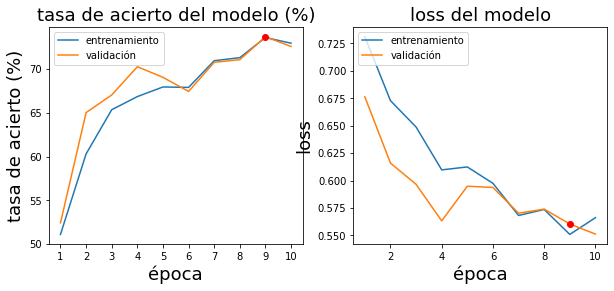

In [114]:
epochs = 40

modelpath="model3_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model3.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [115]:
model3 = load_model(modelpath)

## Resultados Architechture 3


In [116]:
scores_tr = model3.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model3.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()


125/125 [==============================] - 13s 102ms/step - loss: 0.4963 - accuracy: 0.7655
Train loss    : 0.49626949429512024
Train accuracy: 0.765500009059906

63/63 [==============================] - 3s 51ms/step - loss: 0.5629 - accuracy: 0.7330
Val loss    : 0.5628811717033386
Val accuracy: 0.7329999804496765



In [117]:
y_real = validation_generator.classes
y_pred_proba = model3.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.82      0.75       500
           1       0.78      0.65      0.71       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



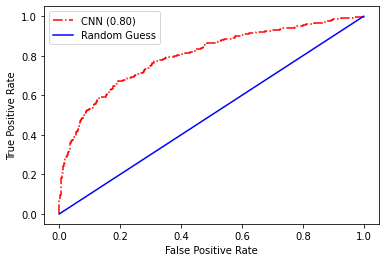

In [118]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

test - val

In [119]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio validation
    shuffle=False,
    class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [120]:
validation_generator2.reset()
X_val, y_val = validation_generator2.next()

In [121]:
X_val.shape

(1000, 120, 120, 3)

In [122]:
X_val.max()

1.0

In [123]:
class_indices = validation_generator2.class_indices
class_indices

{'cats': 0, 'dogs': 1}

Probabilidad perro: 54.4%
Probabilidad gato : 45.6%


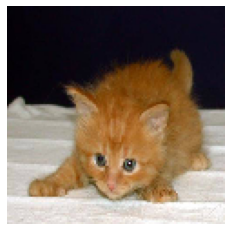

In [124]:
ind_val1 = 84

image = X_val[ind_val1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model3.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model3.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## Early layer feature Maps Architechture 3


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 120, 120, 3)]    0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________





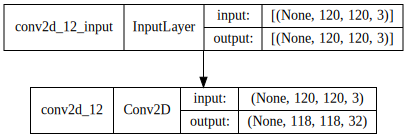

In [125]:
# salida de una sola capa
ncapa = 0
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[ncapa].output)

intermediate_layer_model = Model(inputs=model3.input,
                                 outputs=model3.layers[ncapa].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [126]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

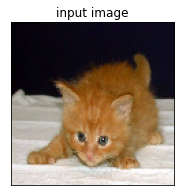

Salidas capa conv2d_12 (1, 118, 118, 32)


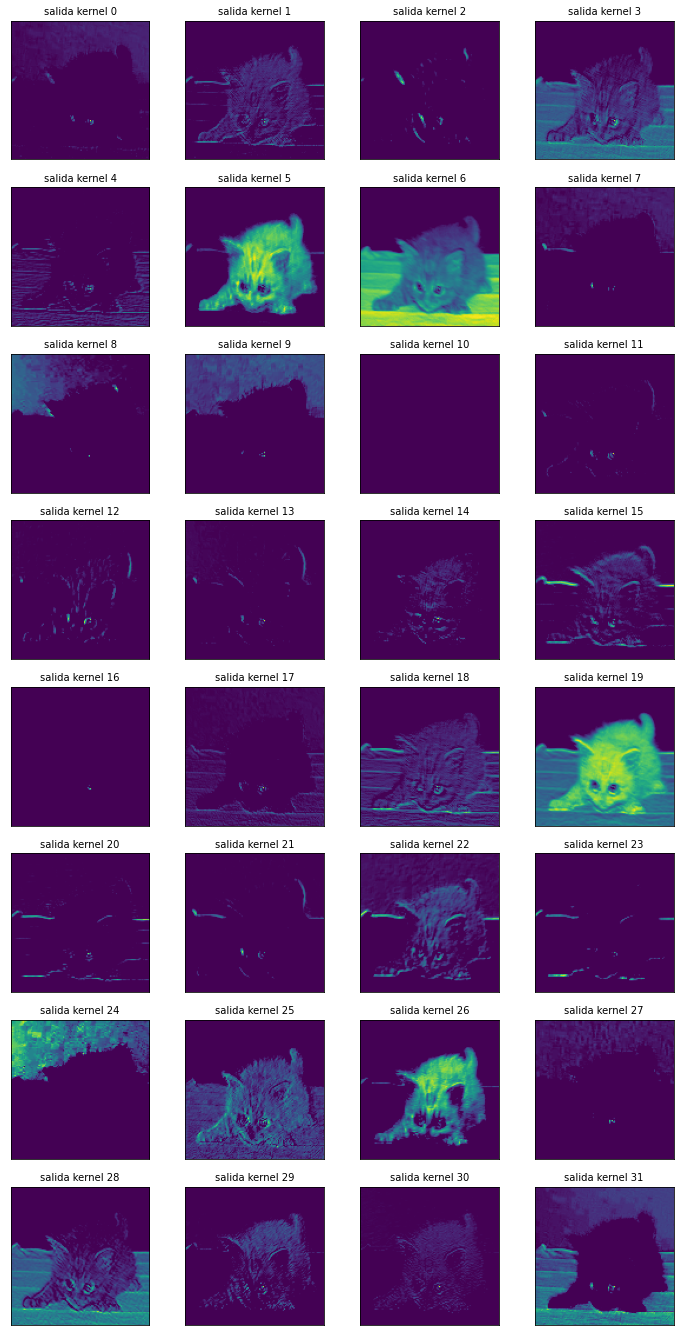

In [127]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Late layer feature Maps Architechture 3



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 120, 120, 3)]    0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                           

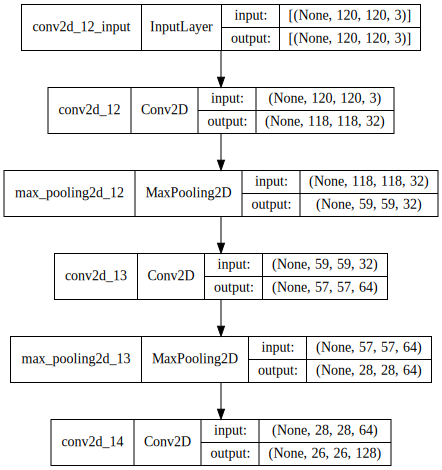

In [128]:
# salida de una sola capa
ncapa = 0

intermediate_layer_model = Model(inputs=model3.input,
                                 outputs=model3.layers[ncapa+4].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [129]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

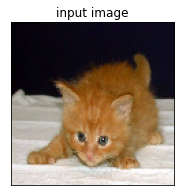

Salidas capa conv2d_14 (1, 26, 26, 128)


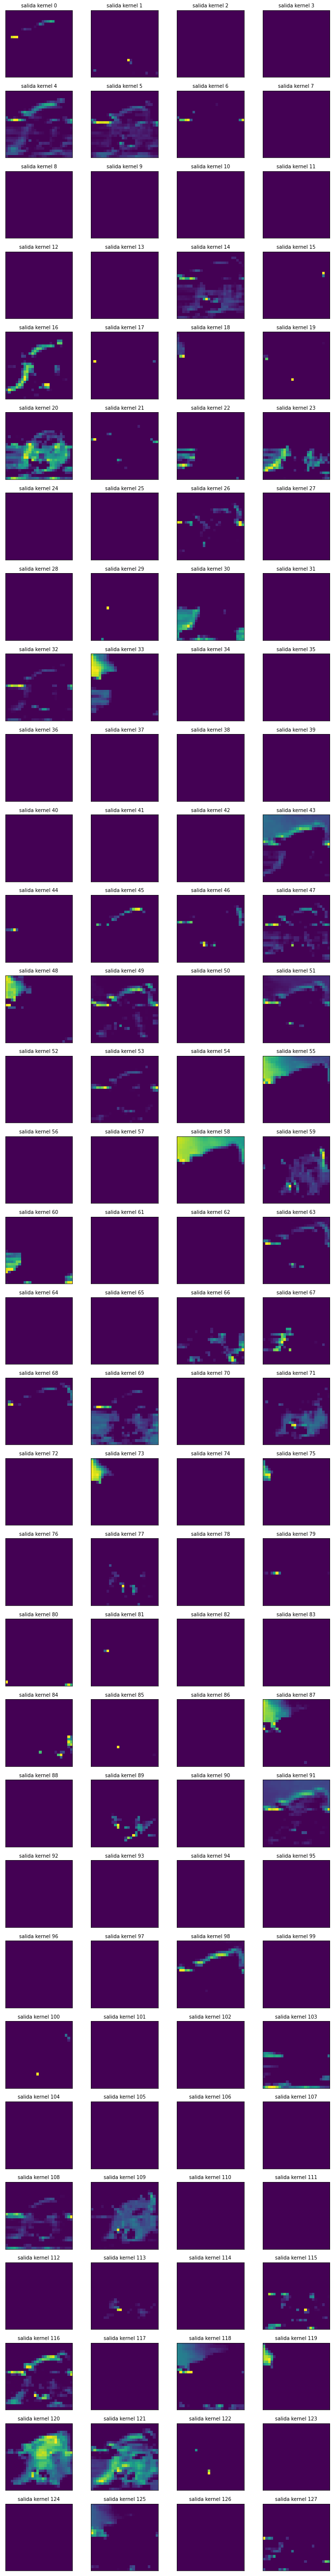

In [130]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)